# Initial Libraries and Prewritten Functions

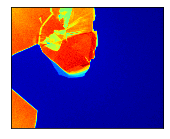

In [146]:
import numpy as np
#import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageColor
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
from sklearn.cluster import KMeans
import argparse
import imutils
import math 
import io
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pylab as pl
from PIL import Image
import numpy as np
import pylab
from colorsys import rgb_to_hsv

WESE_Path='/Users/rohitganti/Desktop/Research/Luis Research/WSe2/'
Monolayer_Path='/Users/rohitganti/Desktop/Research/Luis Research/WSe2/Potential Monolayers'
Samples_Path='/Users/rohitganti/Desktop/Research/Luis Research/WSe2/Usable Samples'

WESE_Array=[]
for items in os.listdir(WESE_Path):
    if items[-4:-1]=='.jp':
        WESE_Array.append(WESE_Path+items)
    
Monolayer_Array=[]
for items in os.listdir(Monolayer_Path):
    Monolayer_Array.append(Monolayer_Path+ items)

Sample_Array=[]
for items in os.listdir(Samples_Path):
    Sample_Array.append(Samples_Path+items)
    

def fig2img(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

def fig2data(fig):
    fig.canvas.draw()
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w,h,4)
    buf = np.roll(buf,3,axis=2)
    return buf

def fig2img2(fig):
    buf = fig2data(fig )
    w, h, d = buf.shape
    return Image.frombytes("RGBA", (w,h), buf.tostring( ) )


def count_pixels(filename):
    color_count = {}
    with Image.open(filename) as image:
        width, height = image.size
        rgb_image = image.convert('RGB')
        for x in range(width):
            for y in range(height):
                rgb = rgb_image.getpixel((x, y))
                if rgb in color_count:
                    color_count[rgb] += 1
                else:
                    color_count[rgb] = 1
    color_array=[]
    for colors in color_count:
        color_array.append(colors)
    return color_count, color_array

def get_max(color_dict,color_array):
    """Returns the color value with the most number of pixes or the set background """
    new_max= color_dict[color_array[0]]
    color=color_array[0]
    for colors in color_dict:
        if int(color_dict[colors])> int(new_max):
            new_max= color_dict[colors]
            color= colors
    return color

def average_tuple(nums):
    result = [sum(x) / len(x) for x in zip(*nums)]
    tup_down= (math.floor(result[0]), math.floor(result[1]), math.floor(result[2]))
    tup_up= (math.ceil(result[0]), math.ceil(result[1]), math.ceil(result[2]))
    return tup_down, tup_up

def get_possible_backgrounds(color_dict, color_array):
    """Returns the five backgrounds"""
    new_dict= color_dict.copy()
    first_back= get_max(new_dict, color_array)
    new_dict.pop(first_back)
    color_array.remove(first_back)
    second_back= get_max(new_dict, color_array)
    new_dict.pop(second_back)
    color_array.remove(second_back)
    third_back= get_max(new_dict, color_array)
    new_dict.pop(third_back)
    color_array.remove(third_back)
    fourth_back= get_max(new_dict,color_array)
    new_dict.pop(fourth_back)
    color_array.remove(fourth_back)
    fifth_back= get_max(new_dict, color_array)
    new_dict.pop(fifth_back)
    color_array.remove(fifth_back)
    all_tuples= first_back, second_back, third_back, fourth_back, fifth_back
    #total_similar_pixels= color_dict[first_back]+color_dict[second_back]+color_dict[third_back]+color_dict[fourth_back]+color_dict[fifth_back]
    return first_back,second_bac,third_back,fourth_back,fifth_back

layers= {
    (0,0,255): 'background blue 1',
    (51,51,255): 'background blue 2',
    (0,0,204): 'background blue 3',
    (0,128,255): 'layer 1',
    (0,102,204): 'layer 1 (2)',
    (51,153,255): 'layer 2',
    (102,178,255): 'layer 3',
    (153,204,255): 'layer 3 (2)',
    (0,255,255): 'layer 4',
    (51,255,255): 'layer 4 (1)',
    (102,255,255): 'layer 5',
    (153,255,255): 'layer 5(1)',
    (255,255,255): 'White background'
}

colors=layers
def to_hsv (color):
    "" "converts color tuples to floats and then to hsv" ""
    return rgb_to_hsv (* [x/255.0 for x in color]) 

def color_dist (c1, c2):
    "" "returns the squared euklidian distance between two color vectors in hsv space" ""
    return sum ((a-b) ** 2 for a, b in zip (to_hsv (c1), to_hsv (c2)))

def min_color_diff (color_to_match, colors):
    "" "returns the` (distance, color_name) `with the minimal distance to` colors` "" "
    return min ((color_dist (color_to_match, test), colors[test]) for test in colors)



def laplacian(image_number):
    imag= cv2.imread(image_number,cv2.IMREAD_COLOR)
    b,g,r= cv2.split(imag)
    image=cv2.merge([r,g,b])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(gray,(3,3),0)
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    #plt.title('Laplacian')
    plt.xticks([])
    plt.yticks([])
    string= image_number+'_Laplacian.jpg'
    plt.imshow(laplacian, cmap='gray')
    plt.savefig(string)
    return string

def sobelx(image_number):
    imag= cv2.imread(image_number,cv2.IMREAD_COLOR)
    b,g,r= cv2.split(imag)
    image=cv2.merge([r,g,b])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(gray,(3,3),0)
    sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
    plt.title('SobelX')
    plt.xticks([])
    plt.yticks([])
    string= image_number+'_SobelX.jpg'
    plt.imshow(sobelx, cmap='gray')
    plt.savefig(string)
    return string

def sobely(imag):
    imag= cv2.imread(image_number,cv2.IMREAD_COLOR)
    b,g,r= cv2.split(imag)
    image=cv2.merge([r,g,b])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(gray,(3,3),0)
    sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
    plt.title('SobelY')
    #plt.xticks([])
    #plt.yticks([])
    string= image_number+'_SobelY.jpg'
    plt.imshow(sobely, cmap='gray')
    plt.imshow(sobely)
    plt.savefig(string)
    return string



image_number= '/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A21_100x.jpg'
img_PIL=Image.open(image_number)
img_cv2= cv2.imread(image_number, cv2.IMREAD_COLOR)

img = Image.open(image_number).convert('L')
z= np.asarray(img)
mydata = z[::1,::1]
fig = pl.figure(facecolor='w')
ax1 = fig.add_subplot(1,2,1)
im = ax1.imshow(mydata,interpolation='nearest',cmap=pl.cm.jet)
#ax1.set_title('2D')
pl.xticks([])
plt.yticks([])
pl.show()

b=fig2img(fig) 
c=b.resize(img.size)
d= c.convert('RGB')
d.save('file.jpg')

color_dict, color_array= count_pixels('file.jpg') #on the changed version of the image
color_dict= dict(color_dict) #all the pixels in the image and the number of pixels associated with it


# only have the blue pixels or their related shades for identifying the single layers potentials
blue_dict={}
threshold=10
for col in color_dict:
    if col[2]== 255 or col[2]==205:
        if col[1]>= 190- threshold or col[1]<= 190+threshold:
            blue_dict[col]= color_dict[col]

blue_dict1={}
restrict=[i for i in range(200,255)]
for col in blue_dict:
    if col[0] not in restrict:
        blue_dict1[col]= blue_dict[col]

In [147]:
blue_dict1

{(255, 255, 255): 5098225,
 (255, 253, 255): 224,
 (255, 254, 255): 2289,
 (255, 252, 255): 280,
 (255, 250, 255): 27,
 (255, 251, 255): 90,
 (196, 194, 205): 1,
 (11, 207, 255): 1,
 (5, 184, 255): 1,
 (1, 151, 255): 1,
 (3, 115, 255): 4,
 (18, 195, 255): 1,
 (10, 172, 255): 1,
 (7, 140, 255): 1,
 (7, 107, 255): 3,
 (6, 75, 255): 1,
 (0, 1, 205): 88,
 (2, 0, 205): 98,
 (11, 163, 255): 1,
 (4, 142, 255): 1,
 (5, 116, 255): 5,
 (5, 89, 255): 2,
 (7, 61, 255): 1,
 (2, 125, 255): 1,
 (0, 106, 255): 34,
 (0, 86, 255): 8,
 (2, 65, 255): 2,
 (0, 72, 255): 9,
 (0, 57, 255): 4,
 (0, 0, 205): 72,
 (0, 34, 255): 2,
 (0, 41, 255): 6,
 (1, 1, 255): 6,
 (0, 7, 255): 7,
 (4, 113, 255): 2,
 (0, 101, 255): 41,
 (0, 91, 255): 11,
 (0, 77, 255): 5,
 (0, 64, 255): 6,
 (7, 8, 255): 1,
 (26, 58, 255): 1,
 (14, 46, 255): 1,
 (10, 38, 255): 1,
 (9, 35, 255): 1,
 (18, 47, 255): 1,
 (7, 36, 255): 1,
 (9, 34, 255): 2,
 (1, 21, 255): 3,
 (2, 25, 255): 1,
 (5, 35, 255): 1,
 (10, 45, 255): 2,
 (19, 55, 255): 1,
 (0

In [148]:
for color_to_match in blue_dict:
    print(min_color_diff(color_to_match, colors))

(0.0, 'White background')
(0.2162870049980777, 'layer 3 (2)')
(0.21937812379853905, 'layer 3 (2)')
(0.16073144944252213, 'layer 3 (2)')
(0.15687812379853905, 'layer 5(1)')
(0.15149824853688756, 'layer 3 (2)')
(0.1537870049980777, 'layer 3 (2)')
(0.15072664359861596, 'layer 5(1)')
(0.14173010380622836, 'layer 5(1)')
(0.1387927720107651, 'layer 5(1)')
(0.14769703960015376, 'layer 5(1)')
(0.14469819300269127, 'layer 5(1)')
(0.13588619761630144, 'layer 5(1)')
(0.21322664359861596, 'layer 3 (2)')
(0.20719819300269127, 'layer 3 (2)')
(0.21019703960015376, 'layer 3 (2)')
(0.18853528557392457, 'layer 3 (2)')
(0.16382256824298347, 'layer 3 (2)')
(0.17547481737793172, 'layer 3 (2)')
(0.18156478277585547, 'layer 3 (2)')
(0.14943315071126484, 'layer 5(1)')
(0.14580930411380236, 'layer 5(1)')
(0.12735101883890815, 'layer 5(1)')
(0.13016532103037298, 'layer 5(1)')
(0.17131238367020563, 'layer 3 (2)')
(0.002935802604604661, 'layer 4')
(0.001657044897261741, 'layer 1')
(0.0002333858783655884, 'layer 1

In [149]:
dict_df={
    "Layer":[],
    "Pixel RGB Value":[],
    "Number of Pixels": []
}
for color_to_match in blue_dict:
    dict_df["Layer"].append(min_color_diff(color_to_match, colors)[1])
    dict_df["Pixel RGB Value"].append(color_to_match)
    dict_df["Number of Pixels"].append(blue_dict[color_to_match])

In [150]:
df= pd.DataFrame(dict_df)
df

Layer  Pixel RGB Value  Number of Pixels
0      White background  (255, 255, 255)           5098225
1           layer 3 (2)  (255, 253, 255)               224
2           layer 3 (2)  (255, 254, 255)              2289
3           layer 3 (2)  (253, 253, 255)                20
4            layer 5(1)  (254, 255, 255)              2096
...                 ...              ...               ...
1343  background blue 3     (2, 22, 205)                 1
1344  background blue 3     (3, 21, 205)                 1
1345  background blue 3     (5, 21, 205)                 1
1346  background blue 3     (7, 16, 205)                 1
1347   White background  (205, 205, 205)                 1

[1348 rows x 3 columns]

In [151]:
df['Number of Pixels'].loc[df['Layer']== 'layer 2']

152     1
181     1
235     1
236     1
260     1
285     1
300     1
340     1
409     1
750     1
792     1
1264    1
1269    1
1271    1
1277    1
1320    1
Name: Number of Pixels, dtype: int64

In [152]:
df['Pixel RGB Value'].loc[df['Layer']== 'layer 2']

152     (42, 125, 205)
181     (39, 150, 255)
235      (45, 96, 205)
236      (58, 96, 205)
260      (28, 96, 255)
285     (45, 126, 205)
300     (26, 136, 255)
340      (43, 88, 205)
409     (59, 119, 205)
750     (27, 138, 255)
792     (28, 166, 255)
1264    (51, 116, 255)
1269    (40, 109, 255)
1271    (31, 100, 255)
1277    (26, 167, 255)
1320    (49, 104, 205)
Name: Pixel RGB Value, dtype: object

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


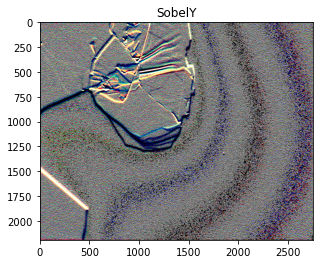

In [153]:
a=Image.open(sobely(image_number))
image= cv2.imread(sobely(image_number))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{(255, 255, 255): 56456,
 (254, 254, 254): 932,
 (253, 253, 253): 600,
 (251, 251, 251): 166,
 (252, 252, 252): 307,
 (250, 250, 250): 55,
 (249, 249, 249): 25,
 (228, 228, 228): 8,
 (227, 227, 227): 8,
 (196, 196, 196): 6,
 (96, 96, 96): 17,
 (191, 191, 191): 3,
 (86, 86, 86): 5,
 (98, 98, 98): 20,
 (190, 190, 190): 4,
 (93, 93, 93): 8,
 (100, 100, 100): 17,
 (193, 193, 193): 3,
 (89, 89, 89): 3,
 (63, 63, 63): 5,
 (204, 204, 204): 7,
 (91, 91, 91): 9,
 (1, 1, 1): 4,
 (23, 23, 23): 4,
 (205, 205, 205): 5,
 (224, 224, 224): 15,
 (222, 222, 222): 21,
 (220, 220, 220): 10,
 (225, 225, 225): 15,
 (20, 20, 20): 7,
 (206, 206, 206): 5,
 (221, 221, 221): 23,
 (16, 16, 16): 10,
 (209, 209, 209): 2,
 (223, 223, 223): 15,
 (40, 40, 40): 21,
 (242, 242, 242): 9,
 (69, 69, 69): 19,
 (113, 113, 113): 10,
 (43, 43, 43): 25,
 (44, 44, 44): 25,
 (45, 45, 45): 21,
 (42, 42, 42): 24,
 (41, 41, 41): 17,
 (3, 3, 3): 2,
 (46, 46, 46): 26,
 (6, 6, 6): 2,
 (47, 47, 47): 23,
 (2, 2, 2): 3,
 (240, 240, 240): 

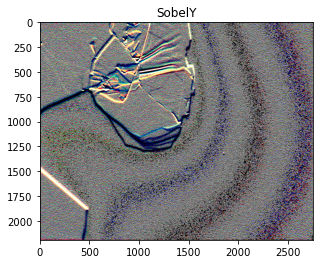

In [154]:
color_dict, color_array= count_pixels(sobely(image_number))
sobel_dict= dict(color_dict)
sobel_dict

In [155]:
WESE_Array[4]

'/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A112_20x.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


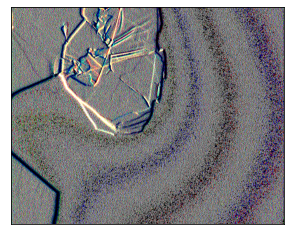

In [156]:
imag= cv2.imread(image_number,cv2.IMREAD_COLOR)
b,g,r = cv2.split(imag)
image=cv2.merge([r,g,b])
laplacian = cv2.Laplacian(image,cv2.CV_64F)
sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)

plt.xticks()
plt.imshow(sobelx, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('sobelx.jpg')

### Number of broken pieces per image

In [159]:
image_number= WESE_Array[5]#'186503079_981061809099190_7228838060409850774_n.jpg' #WESE_Array[4]
#a=Image.open(sobelx(image_number))
image= Image.open(sobely(image_number))
color_dict, color_array= count_pixels(sobely(image_number))
sobel_dict= dict(color_dict)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,threshold1=300,threshold2=500)

TypeError: 'numpy.ndarray' object is not callable

In [160]:
plt.imshow(edges)
plt.show()

NameError: name 'edges' is not defined

In [161]:
gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
edges= cv2.Canny(gray, 0,1)
contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
number_of_objects_in_image= len(contours)
print ("The number of objects in this image: ", str(number_of_objects_in_image))

The number of objects in this image:  191910


In [ ]:
pieces_data={
    "Piece Number":[],
    "Area": [],
    "Perimeter":[],
    "Epsilon":[], #maximum distance from contour to approximated contour
    "Approximation":[], #
    "Convexity":[]
}

count=1
for i in contours:
    pieces_data["Piece Number"].append(count)
    pieces_data["Area"].append(cv2.contourArea(i))
    pieces_data["Perimeter"].append(cv2.arcLength(i,True))
    pieces_data["Epsilon"].append(0.1*cv2.arcLength(i,True))
    pieces_data["Approximation"].append(cv2.approxPolyDP(i,0.1*cv2.arcLength(i,True),True))
    pieces_data["Convexity"].append(cv2.isContourConvex(i))
    count= count+1
    
material_data= pd.DataFrame(pieces_data)
material_data

In [ ]:
material_data1= material_data.loc[material_data['Area']!= 0.0]
material_data2= material_data1.loc[material_data1['Convexity']==True]
material_data2 #identifies the shapes which have a definite area and a convexity which gives the crystallographic direction

In [ ]:
import numpy as np
from itertools import product

arr = np.array([
    list(range(300))
    for _ in range(200)
])

print(arr.shape)
# (200, 300)

pixels = arr.reshape(-1)

""" n-dimension solution
    coords = map(range, arr.shape)
    indices = np.array(list( product(*coords) ))
"""
xs = range(arr.shape[0])
ys = range(arr.shape[1])
indices = np.array(list(product(xs, ys)))

import pandas as pd
pd.options.display.max_rows = 20

index = pd.Series(pixels, name="pixels")
df = pd.DataFrame({
    "x" : indices[:, 0],
    "y" : indices[:, 1]
}, index=index)
print(df)

In [ ]:
## color = (235, 187, 7)
im = Image.open('file.jpg')
rgb_im = im.convert('RGB')
for x in range(2):
    for y in range(2):
        r, g, b = rgb_im.getpixel((x, y))
        print(x,y)

## This portion contains importing the single layers into another image or normalizing the image

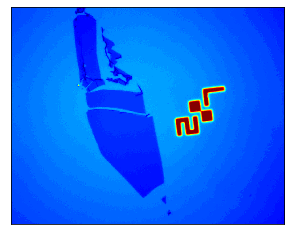

In [99]:
image_number='186503079_981061809099190_7228838060409850774_n.jpg'
img = Image.open(image_number).convert('L')
z= np.asarray(img)
mydata = z[::1,::1]
fig = plt.figure(facecolor='w')
ax1= fig.subplots(1)
#ax1 = fig.add_subplot(1,1,1)
im = ax1.imshow(mydata,interpolation='nearest',cmap=plt.cm.jet)
#ax1.set_title('2D')
plt.xticks([])
plt.yticks([])
plt.show()

In [68]:
type(fig)

matplotlib.figure.Figure

In [69]:
fig.savefig('file1.jpg')

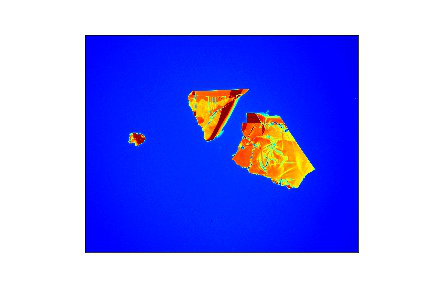

In [70]:
Image.open('file1.jpg')

In [135]:
imtrail= Image.open('file1.jpg')

In [139]:
#sobelx = cv2.Sobel(imtrail,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(imtrail,cv2.CV_64F,0,1,ksize=5)

plt.xticks()
plt.imshow(sobelx, cmap='gray')

error: OpenCV(4.5.2) :-1: error: (-5:Bad argument) in function 'Sobel'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


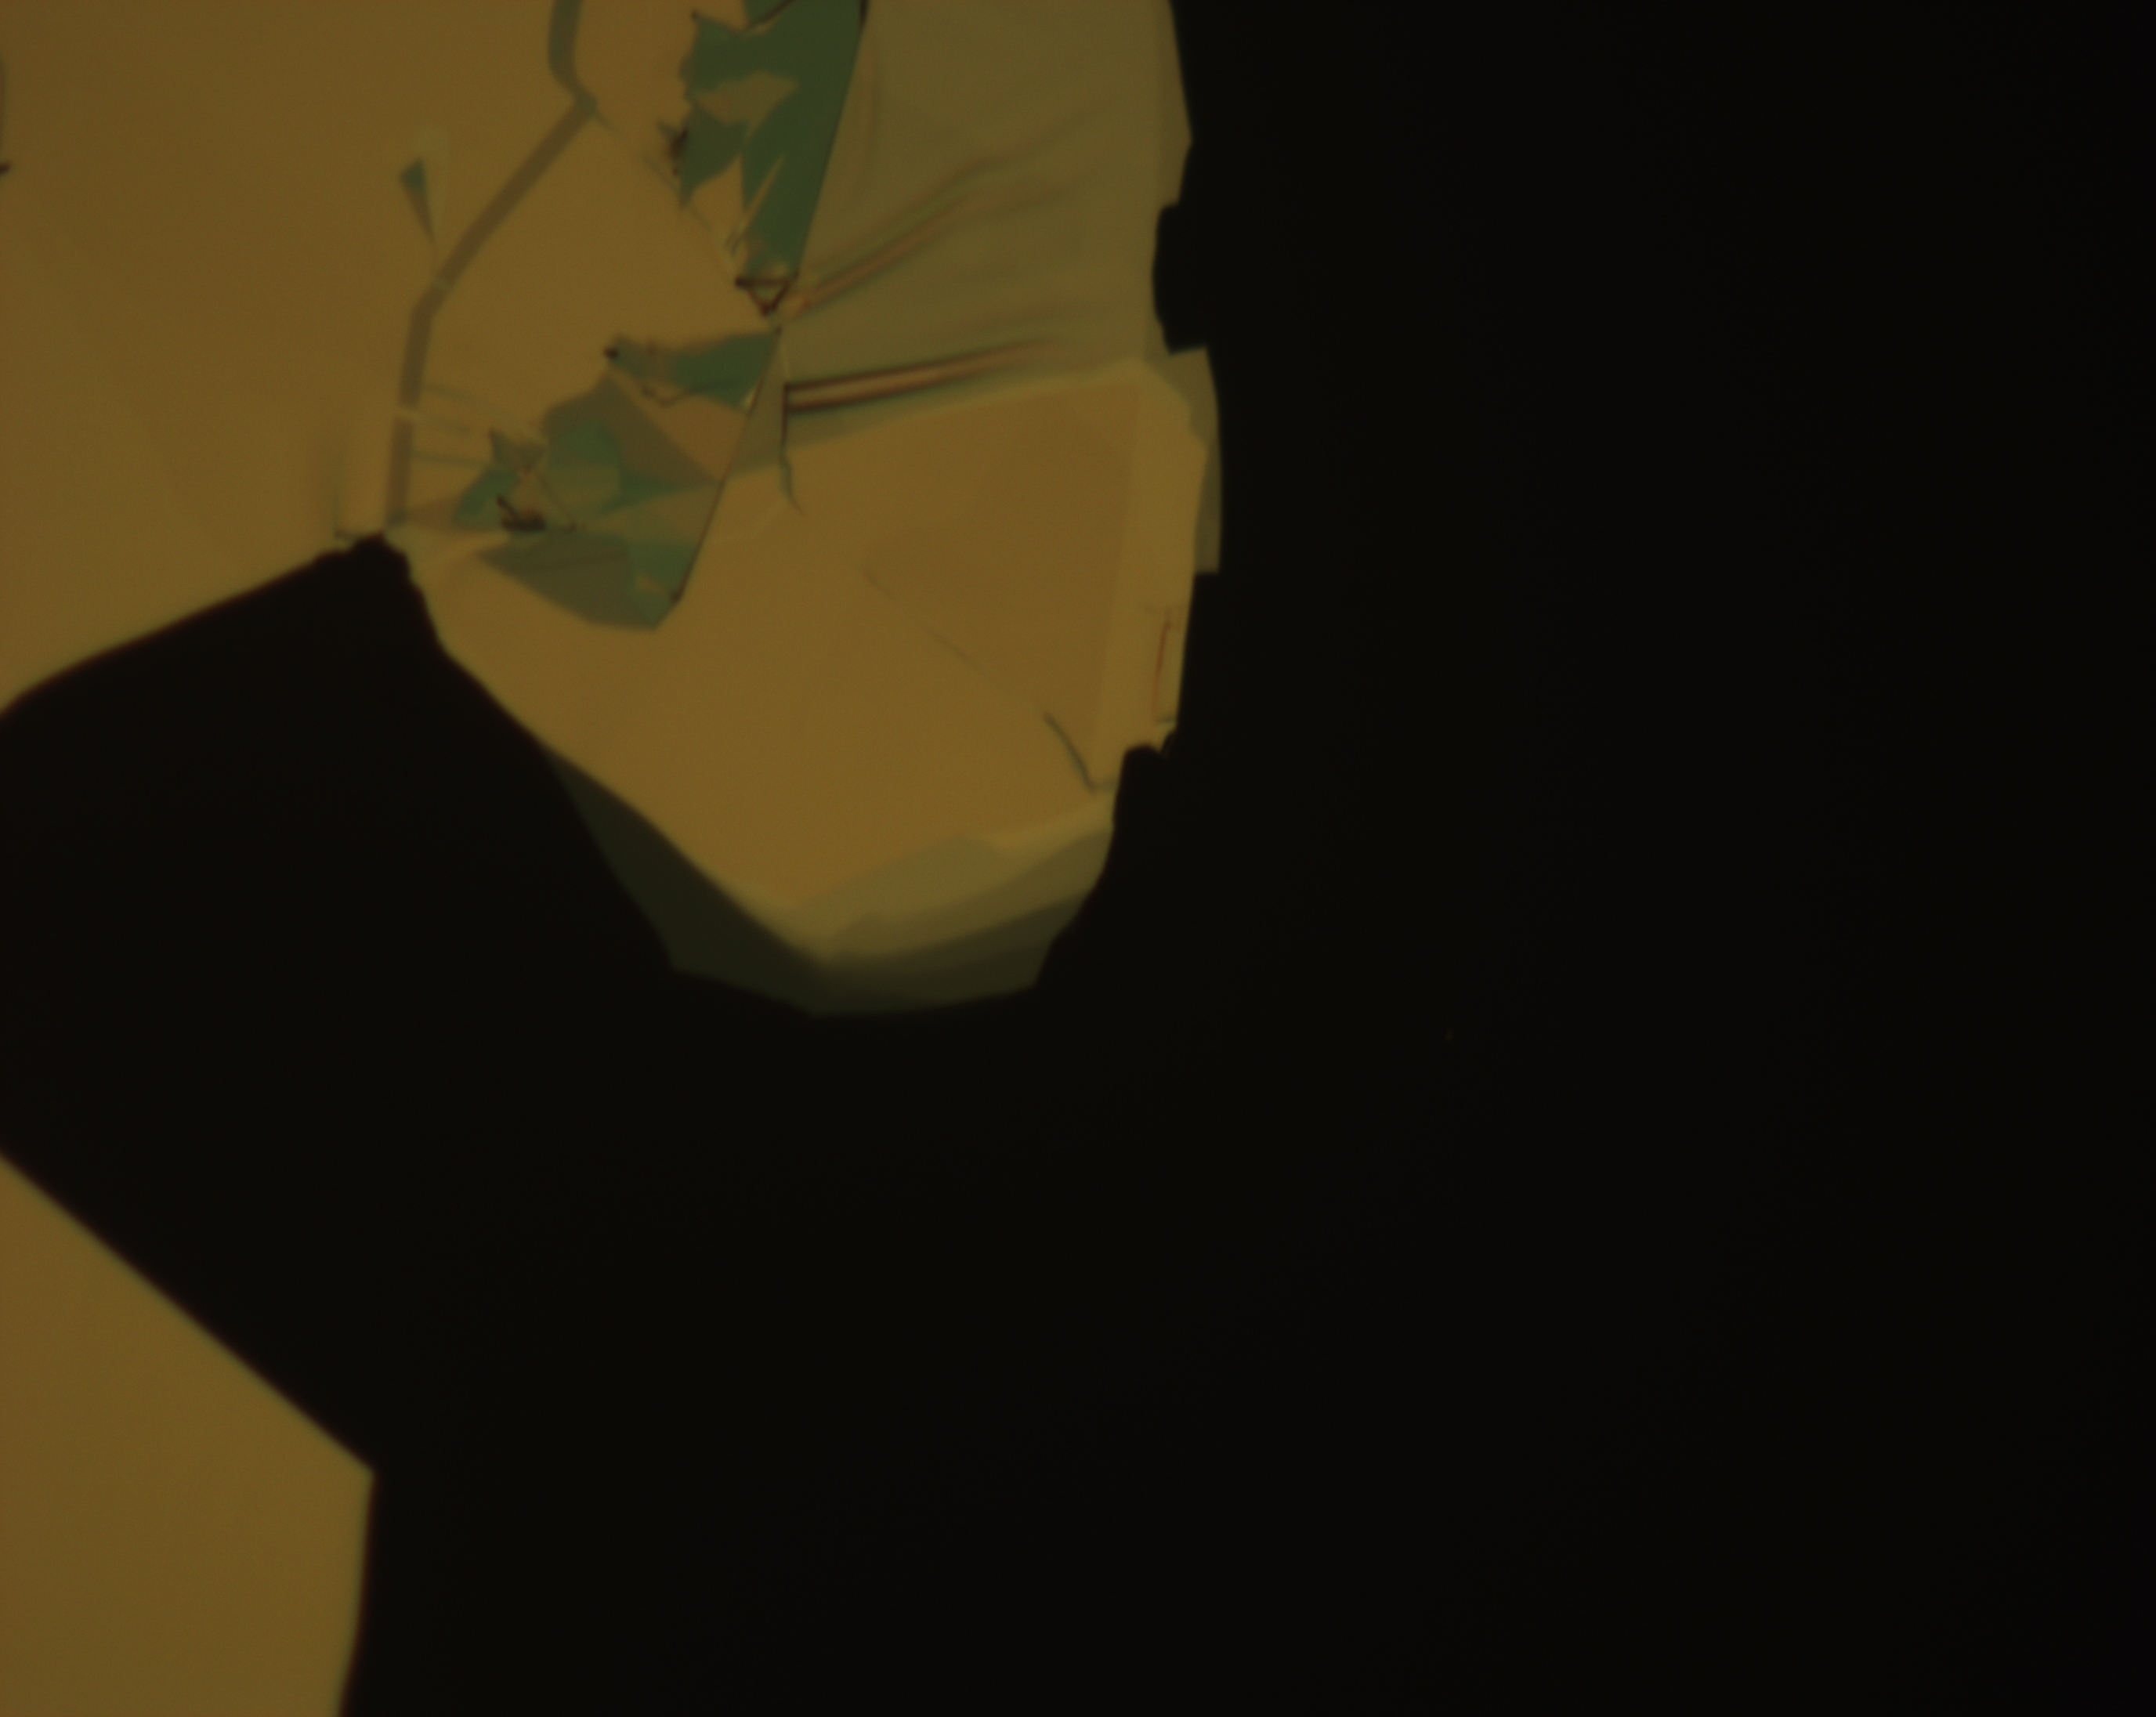

In [81]:
Image.open(WESE_Array[7])

In [83]:
WESE_Array

['/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A102_20x.jpg',
 '/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A96_20X.jpg_SobelY.jpg',
 '/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A112_20x.jpg',
 '/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A54_10x.jpg',
 '/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A2_20x.jpg_SobelY.jpg',
 '/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A44_10x.jpg',
 '/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A3_50x.jpg_SobelY.jpg',
 '/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A21_100x.jpg',
 '/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A20_100x.jpg',
 '/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A71_20x.jpg',
 '/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A61_20x.jpg',
 '/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A127_10x.jpg',
 '/Users/rohitganti/Desktop/Research/Luis Research/WSe2/A137_10x.jpg',
 '/Users/rohitganti/Desktop/Research/Luis Research/WS

In [102]:
ac =Image.open(WESE_Array[8])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


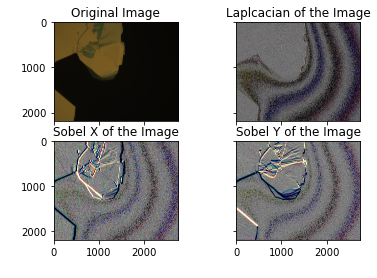

In [142]:
image_number=WESE_Array[7]
imag= cv2.imread(image_number, cv2.IMREAD_COLOR)
b,g,r= cv2.split(imag)
image= cv2.merge([r,g,b])
gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img= cv2.GaussianBlur(gray, (3,3),0)
laplacian= cv2.Laplacian(image, cv2.CV_64F)
sobelx= cv2.Sobel(image,cv2.CV_64F,1,0, ksize=5)
sobely= cv2.Sobel(image,cv2.CV_64F,0,1, ksize=5)
fig, axs=plt.subplots(2,2)
axs[0,0].imshow(image)
axs[0,0].set_title('Original Image')
axs[0,1].imshow(laplacian, cmap='gray')
axs[0,1].set_title('Laplcacian of the Image')
axs[1,0].imshow(sobelx, cmap='gray')
axs[1,0].set_title('Sobel X of the Image')
axs[1,1].imshow(sobely, cmap='gray')
axs[1,1].set_title('Sobel Y of the Image')
for ax in axs.flat:
    ax.set(xlabel=' ', ylabel=' ')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.show()

In [145]:
hierarchy

NameError: name 'hierarchy' is not defined

In [ ]:
t